In [1]:
set1 = [
    [0, 204, 0],
    [204, 0, 0],
    [0, 204, 0],
    [127, 127, 0],
    [127, 0, 127],
    [0, 127, 127],
    [76, 153, 0],
    [153, 0, 76],
    [76, 0, 153],
    [153, 76, 0],
    [76, 0, 153],
    [153, 0, 76],
    [204, 51, 127],
    [204, 51, 127],
    [51, 204, 127],
    [51, 127, 204],
    [127, 51, 204],
    [127, 204, 51],
    [76, 76, 178],
    [76, 178, 76],
    [178, 76, 76],
]


# Set 3: Analogous Colors
set3 = [
    (227, 38, 54),     # Crimson
    (255, 140, 0),     # Dark Orange
    (255, 165, 0),     # Orange
    (255, 195, 0),     # Orange Peel
    (255, 225, 0),     # Canary Yellow
    (255, 255, 0),     # Yellow
    (218, 165, 32),    # Golden Rod
    (188, 143, 143),   # Rosy Brown
    (205, 92, 92),     # Indian Red
    (188, 143, 143),   # Rosy Brown
    (244, 164, 96),    # Sandy Brown
    (210, 105, 30),    # Chocolate
    (139, 69, 19),     # Saddle Brown
    (165, 42, 42),     # Brown
    (128, 0, 0),       # Maroon
    (85, 107, 47),     # Dark Olive Green
    (107, 142, 35),    # Olive Drab
    (124, 252, 0),     # Lawn Green
    (127, 255, 0),     # Chartreuse
    (173, 255, 47),    # Green Yellow
]

# Set 4: Triadic Colors
set4 = [
    (255, 0, 0),       # Red
    (0, 255, 0),       # Lime
    (0, 0, 255),       # Blue
    (255, 255, 0),     # Yellow
    (0, 255, 255),     # Cyan
    (255, 0, 255),     # Magenta
    (192, 192, 192),   # Silver
    (128, 128, 0),     # Olive
    (128, 0, 128),     # Purple
    (0, 128, 128),     # Teal
    (255, 69, 0),      # Orange Red
    (219, 112, 147),   # Pale Violet Red
    (199, 21, 133),    # Medium Violet Red
    (255, 20, 147),    # Deep Pink
    (255, 105, 180),   # Hot Pink
    (70, 130, 180),    # Steel Blue
    (100, 149, 237),   # Cornflower Blue
    (0, 191, 255),     # Deep Sky Blue
    (30, 144, 255),    # Dodger Blue
    (65, 105, 225),    # Royal Blue
]

# Set 5: Split-Complementary Colors
set5 = [
    (255, 0, 0),       # Red
    (0, 250, 154),     # Medium Spring Green
    (32, 178, 170),    # Light Sea Green
    (218, 112, 214),   # Orchid
    (199, 21, 133),    # Medium Violet Red
    (219, 112, 147),   # Pale Violet Red
    (255, 99, 71),     # Tomato
    (255, 215, 0),     # Gold
    (0, 206, 209),     # Dark Turquoise
    (123, 104, 238),   # Medium Slate Blue
    (147, 112, 219),   # Medium Purple
    (60, 179, 113),    # Medium Sea Green
    (32, 178, 170),    # Light Sea Green
    (50, 205, 50),     # Lime Green
    (72, 209, 204),    # Medium Turquoise
    (25, 25, 112),     # Midnight Blue
    (255, 140, 0),     # Dark Orange
    (255, 165, 0),     # Orange
    (240, 230, 140),   # Khaki
    (189, 183, 107)    # Dark Khaki
]

In [2]:
import os
os.chdir("../")

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="global_config")
    print(OmegaConf.to_yaml(cfg))

project_root_path: ${hydra:runtime.cwd}
experiment_output_path: ${project_root_path}/output/${experiment_name}
ckpt_path: null
experiment_name: null
train_seed: 123
test_seed: 123
logger:
  _target_: lightning.pytorch.loggers.WandbLogger
  project: jigsaw3d_translation_only
  name: ${experiment_name}
  save_dir: ${experiment_output_path}/training
inference_dir: null
trainer:
  accelerator: gpu
  max_epochs: 4000
  num_sanity_val_steps: 0
  check_val_every_n_epoch: 100
  precision: 32
  log_every_n_steps: 10
checkpoint_monitor:
  _target_: lightning.pytorch.callbacks.ModelCheckpoint
  monitor: eval/part_acc
  mode: max
  save_last: true
  save_top_k: 3
  every_n_epochs: ${trainer.check_val_every_n_epoch}
  filename: '{epoch:03d}'
  dirpath: ${experiment_output_path}/training
data:
  batch_size: 50
  val_batch_size: 50
  num_workers: 10
  save_nepoch: 50
  val_nepoch: 100
  data_fn: everyday.{}.txt
  data_dir: ../vq_jigsaw/latent_data/bottle_volume_constrained_no_rot/train/
  data_val_di

In [4]:
from xgutils.vis import visutil, fresnelvis, vis3d
from xgutils.vis.fresnelvis import FresnelRenderer
import numpy as np
import trimesh
import os
from xgutils import sysutil
from pytorch3d import transforms


camera_kwargs = {
    'camera_type': 'orthographic',  # Choose between 'perspective' or 'orthographic'
    'fit_camera': False,           # Set to True to auto-fit the camera to the scene
    'camPos': (10, 10, 10),        # Camera position in the scene (x, y, z)
    'camLookat': (0, 0, 0),        # Point in space that the camera looks at (x, y, z)
    'camUp': (0, 1, 0),            # 'Up' direction for the camera (x, y, z)
    'camHeight': 5,                # Height of the camera lens
    'resolution': (256, 256),       # Camera image resolution
    'samples': 8
    # Additional parameters can be added as needed
}

render_kwargs = {
    # Define additional rendering settings (preview, shadow_catcher, etc.)
    "preview": True,
    "shadow_catcher": False,
    # "min_y": -1,
    # ... other kwargs that your renderer might require
}




/localhome/zwa170/miniconda3/envs/assembly/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import glob

inf_dir = "forward_translation/custom_0.01_fixed/"
file = str(209)

path = os.path.join(inf_dir, file)

# Find the first file that matches the predict pattern
transformation = np.load(f"{path}/translation.npy")
gt_transformation = np.load(f"{path}/gt.npy")

print(transformation.shape)


# scale = np.load(f"../vq_jigsaw/latent_data/bottle_volume_constrained_no_rot/val/{file}.npz")["scale"]

(1000, 14, 3)


In [6]:
import torch

def normalize_to_centroid(vertices, translation):
    centroid = np.mean(vertices, axis=0)
    return vertices - translation

import re
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(_nsre, s)]


with open(f"{path}/mesh_file_path.txt", "r") as f:
    file_path = f.read()

mesh_dir_path = os.path.join("../Breaking-Bad-Dataset.github.io/data/volume_constrained/", file_path)

obj_files = [file for file in os.listdir(mesh_dir_path) if file.endswith('.obj')]
parts = []
obj_files.sort()

print(obj_files)

count = 0

for i, obj_file in enumerate(obj_files):
    full_path_to_obj = os.path.join(mesh_dir_path, obj_file)
    mesh = trimesh.load(full_path_to_obj)
    # print(obj_file)

    translation = gt_transformation[i, :3]

    vert = normalize_to_centroid(np.array(mesh.vertices), translation)
        
    # Create a dictionary for each part containing vertices and faces
    part = {
        "vert": vert,
        "face": np.array(mesh.faces)
        # Assuming FresnelaRenderer uses "vert" and "face" keywords
    }
    
    parts.append(part)
    count += 1


['piece_0.obj', 'piece_1.obj', 'piece_10.obj', 'piece_11.obj', 'piece_12.obj', 'piece_13.obj', 'piece_2.obj', 'piece_3.obj', 'piece_4.obj', 'piece_5.obj', 'piece_6.obj', 'piece_7.obj', 'piece_8.obj', 'piece_9.obj']


In [7]:
def render_parts(parts, camera_kwargs, trans, **kwargs):
    renderer = FresnelRenderer(camera_kwargs, **kwargs, lights="lightbox")

    rotation_matrix = trimesh.transformations.rotation_matrix(
        np.radians(-90), [1, 0, 0], point=[0, 0, 0]
    )

    for i,shape in enumerate(parts):

        translation = trans[i][:3]
        # normalized to unit quaternion
        vert = shape["vert"]

        vert = vert + translation

        vert = vert.dot(rotation_matrix[:3, :3].T)
        
        # color = fresnelvis.unique_colors[i]
        color = np.array(set3[i]) / 255.0
        renderer.add_mesh(vert, face=shape["face"], color=color,
            solid=0., roughness=.2, specular=.8, spec_trans=0., metal=0.2
        )

    img = renderer.render(**kwargs)
    return img

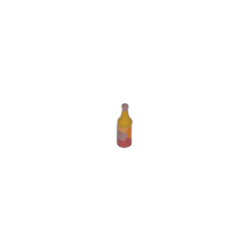

(<Figure size 256x256 with 1 Axes>, <Axes: >)

In [8]:
img = render_parts(parts, camera_kwargs, trans=gt_transformation, **render_kwargs)
visutil.showImg(img)


In [9]:
print(transformation.shape)

(1000, 14, 3)


In [10]:
imgs = []
# print(parts)
for i in sysutil.progbar(range(1, transformation.shape[0])):
    trans = transformation[i]
    img = render_parts(parts, camera_kwargs, trans, **render_kwargs)
    imgs.append(img)


# visutil.imgarray2video(targetPath=f"./render_results/rotation_only_one_part/{file}.mp4", img_list=imgs, extend_endframes=50)
visutil.showVidNotebook(imgs=imgs, duration=20., end_frames=20)

100%|##########| 999/999 [00:33<00:00, 29.78it/s]


Executing command:  ffmpeg -framerate 49.95 -f image2 -i /localhome/zwa170/.temp_imgarray2video/_IHWII1KCV8/%d.png -c:v libx264 -pix_fmt yuv420p -r 25 /localhome/zwa170/.temp_imgarray2video/H6GN6SPWMR.mp4  -y
{'BASH_ENV': '/cvmfs/rcg.sfu.ca/sw/env/Ubuntu/20.04/amd64/CORE/init/bash', 'BASH_FUNC_ml%%': '() {  module ml "$@"\n}', 'BASH_FUNC_module%%': '() {  unset _mlshdbg;\n if [ "${MODULES_SILENT_SHELL_DEBUG:-0}" = \'1\' ]; then\n case "$-" in \n *v*x*)\n set +vx;\n _mlshdbg=\'vx\'\n ;;\n *v*)\n set +v;\n _mlshdbg=\'v\'\n ;;\n *x*)\n set +x;\n _mlshdbg=\'x\'\n ;;\n *)\n _mlshdbg=\'\'\n ;;\n esac;\n fi;\n unset _mlre _mlIFS;\n if [ -n "${IFS+x}" ]; then\n _mlIFS=$IFS;\n fi;\n IFS=\' \';\n for _mlv in ${MODULES_RUN_QUARANTINE:-};\n do\n if [ "${_mlv}" = "${_mlv##*[!A-Za-z0-9_]}" -a "${_mlv}" = "${_mlv#[0-9]}" ]; then\n if [ -n "`eval \'echo ${\'$_mlv\'+x}\'`" ]; then\n _mlre="${_mlre:-}${_mlv}_modquar=\'`eval \'echo ${\'$_mlv\'}\'`\' ";\n fi;\n _mlrv="MODULES_RUNENV_${_mlv}";\n _mlre="${_

'/localhome/zwa170/.temp_imgarray2video/H6GN6SPWMR.mp4'